## Packages & Data Loading

In [ ]:
pip install graphviz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
from sklearn.linear_model import RidgeCV

In [ ]:
from google.colab import files
emissions = files.upload()

Saving Cleaned_State_Emissions_by_Year.csv to Cleaned_State_Emissions_by_Year.csv


In [ ]:
emissions_data = pd.read_csv('Cleaned_State_Emissions_by_Year.csv')
emissions_data.head()

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715384,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815


## EDA

In [ ]:
df = pd.read_csv('/content/Cleaned_State_Emissions_by_Year.csv')
# Reshape the DataFrame to long format for all years
df1_melted = df.melt(id_vars='State', value_vars=[str(year) for year in range(1970, 2023)],
                            var_name='Year', value_name='Emissions')
df1_melted['Year'] = df1_melted['Year'].astype(int)
df1_melted['Emissions'] = pd.to_numeric(df1_melted['Emissions'], errors='coerce')

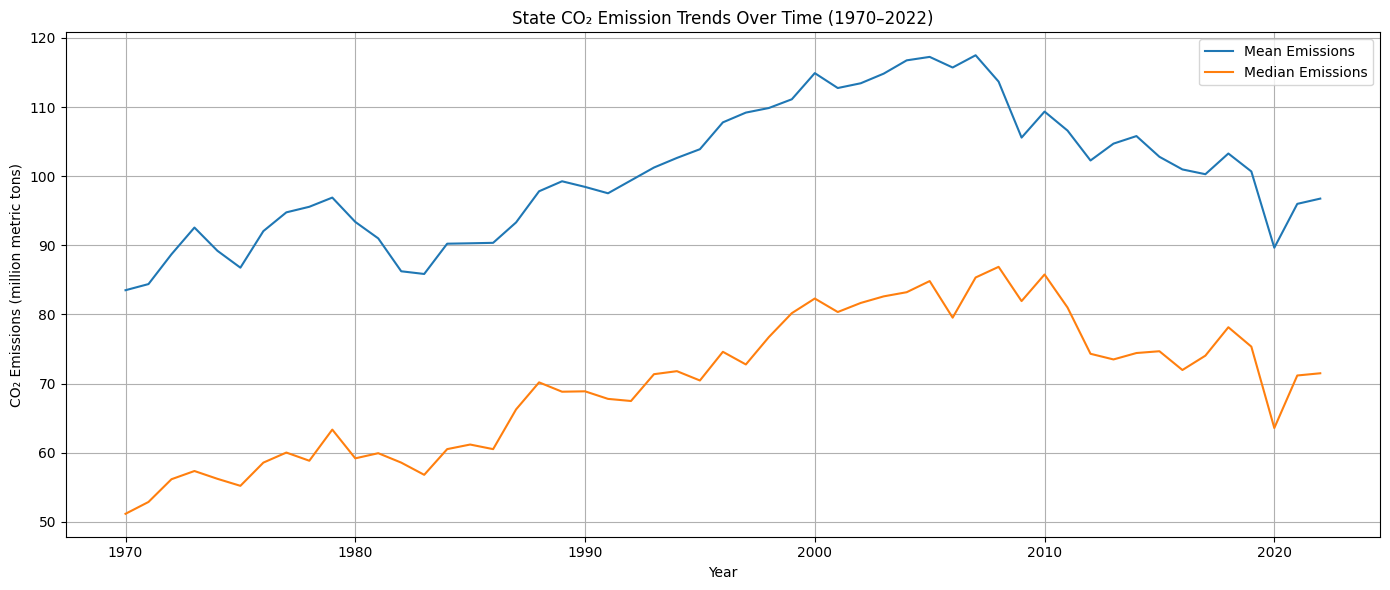

In [ ]:
# Group by year and calculate summary statistics for all states
emissions_trend = df1_melted.groupby('Year')['Emissions'].agg(['mean', 'median', 'max', 'min'])

# Plot emission trends over time
plt.figure(figsize=(14, 6))
plt.plot(emissions_trend.index, emissions_trend['mean'], label='Mean Emissions')
plt.plot(emissions_trend.index, emissions_trend['median'], label='Median Emissions')
plt.title('State CO₂ Emission Trends Over Time (1970–2022)')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (million metric tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

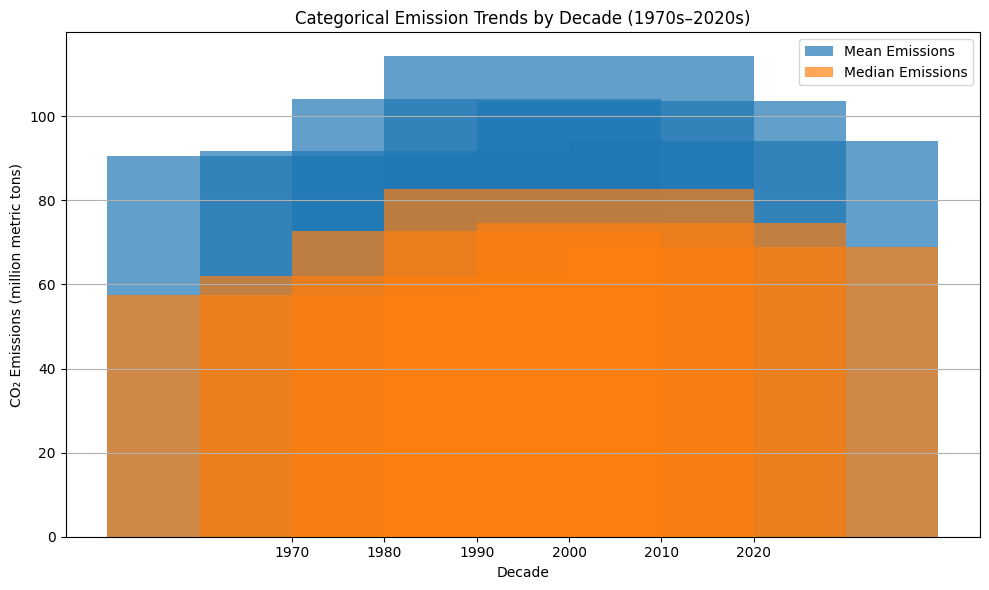

In [ ]:
# Categorize year into decade
df1_melted['Decade'] = (df1_melted['Year'] // 10) * 10

# Group by decade and summarize
decade_summary = df1_melted.groupby('Decade')['Emissions'].agg(['mean', 'median']).reset_index()

# Plot as grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 4
x = decade_summary['Decade'].astype(str)
plt.bar(x, decade_summary['mean'], width=bar_width, label='Mean Emissions', alpha=0.7)
plt.bar(x, decade_summary['median'], width=bar_width, label='Median Emissions', alpha=0.7, bottom=0)

plt.title('Categorical Emission Trends by Decade (1970s–2020s)')
plt.xlabel('Decade')
plt.ylabel('CO₂ Emissions (million metric tons)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

By breaking year into decades - we can classify the year variable into several categories: Prior 1980s, 1980s-2020s, post 2020s.

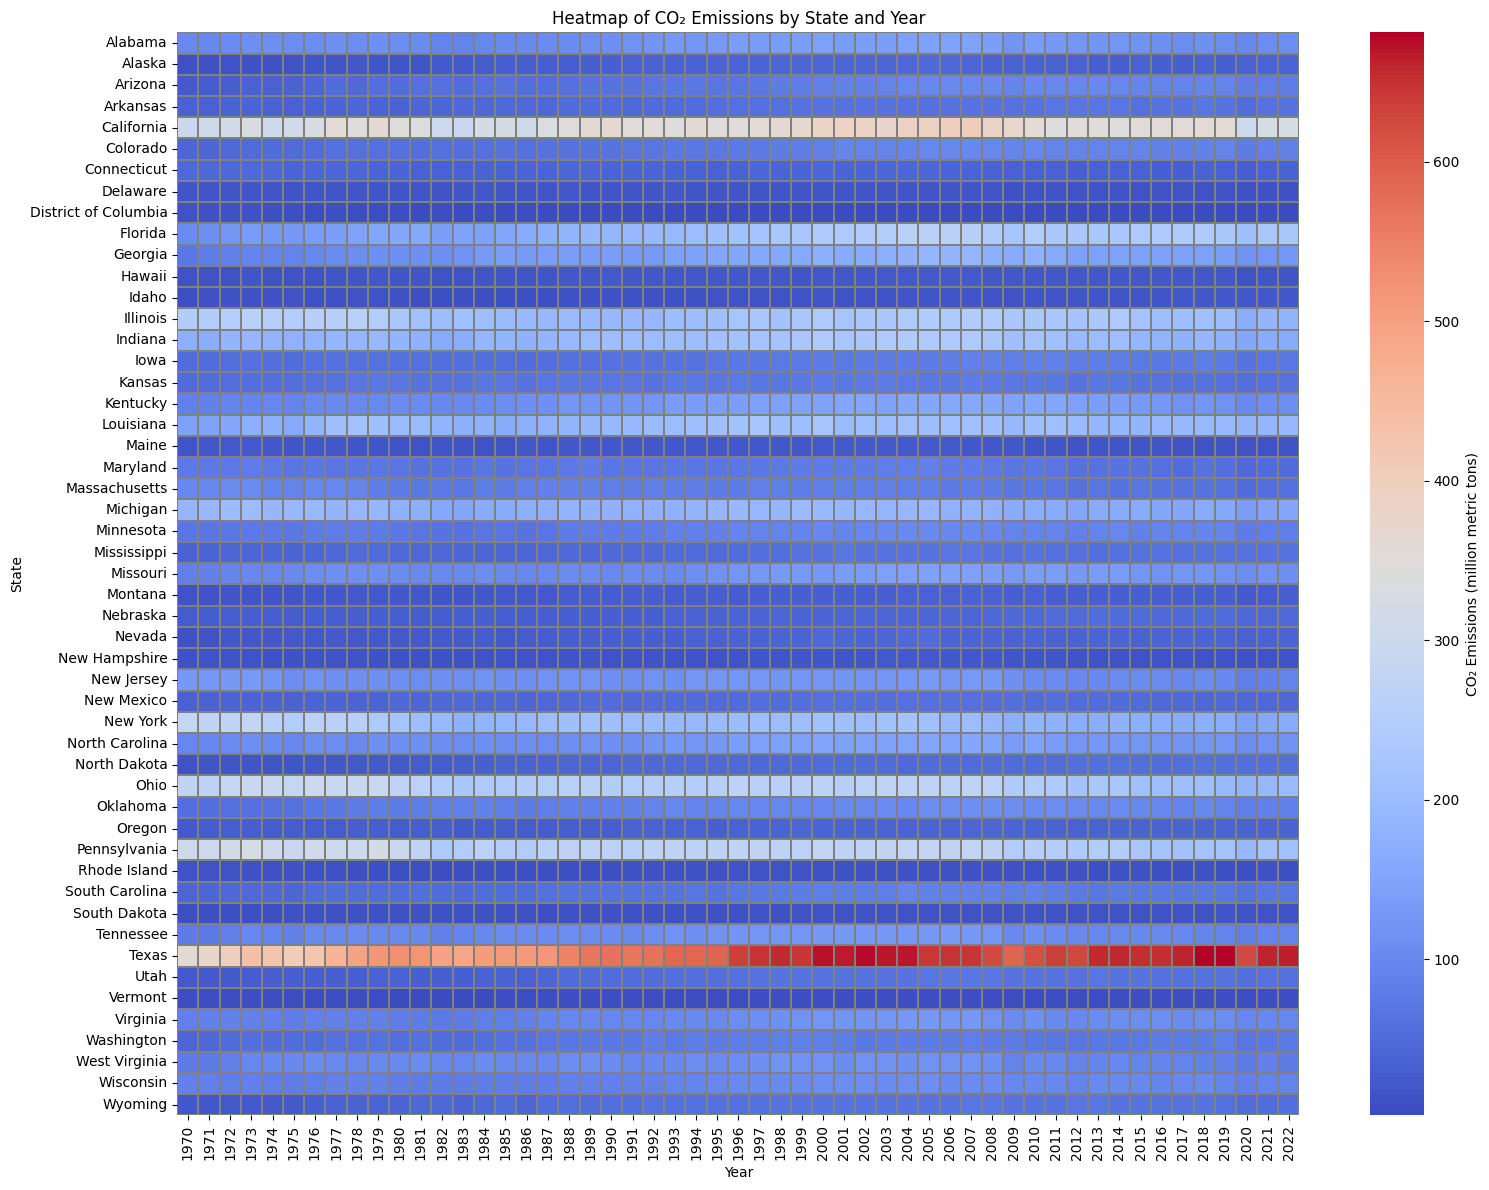

In [ ]:
# Pivot the data for heatmap (States as rows, Years as columns)
heatmap_data = df1_melted.pivot(index='State', columns='Year', values='Emissions')

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=0.3, linecolor='gray', cbar_kws={'label': 'CO₂ Emissions (million metric tons)'})
plt.title('Heatmap of CO₂ Emissions by State and Year')
plt.xlabel('Year')
plt.ylabel('State')
plt.tight_layout()
plt.show()

In [ ]:
df2 = pd.read_csv('/content/Cleaned_2022_Sector_Emissions.csv')

<ipython-input-8-de69b8fc4c4e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dominant_counts.index, y=dominant_counts.values, palette='pastel')


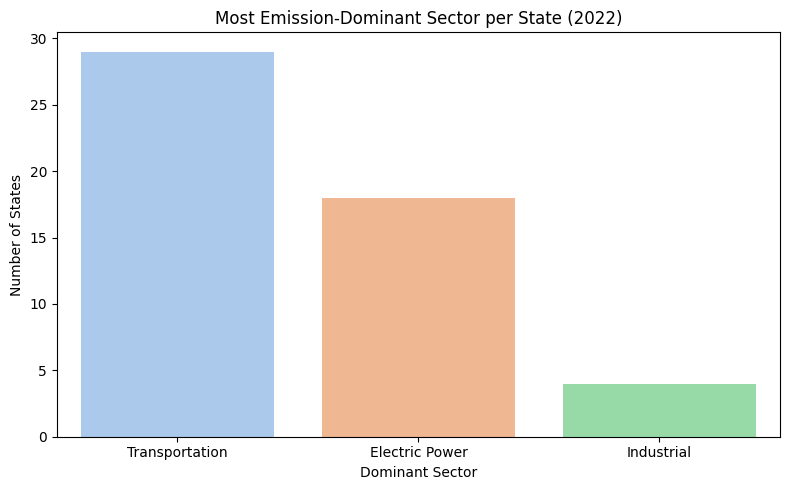

In [ ]:
# Create a new categorical column for dominant emission sector per state
sector_cols = ['Commercial', 'Electric Power', 'Residential', 'Industrial', 'Transportation']
df2['Dominant Sector'] = df2[sector_cols].astype(float).idxmax(axis=1)

# Count how many states are dominated by each sector
dominant_counts = df2['Dominant Sector'].value_counts()

# Plot bar chart for dominant sector frequency
plt.figure(figsize=(8, 5))
sns.barplot(x=dominant_counts.index, y=dominant_counts.values, palette='pastel')
plt.title('Most Emission-Dominant Sector per State (2022)')
plt.xlabel('Dominant Sector')
plt.ylabel('Number of States')
plt.tight_layout()
plt.show()

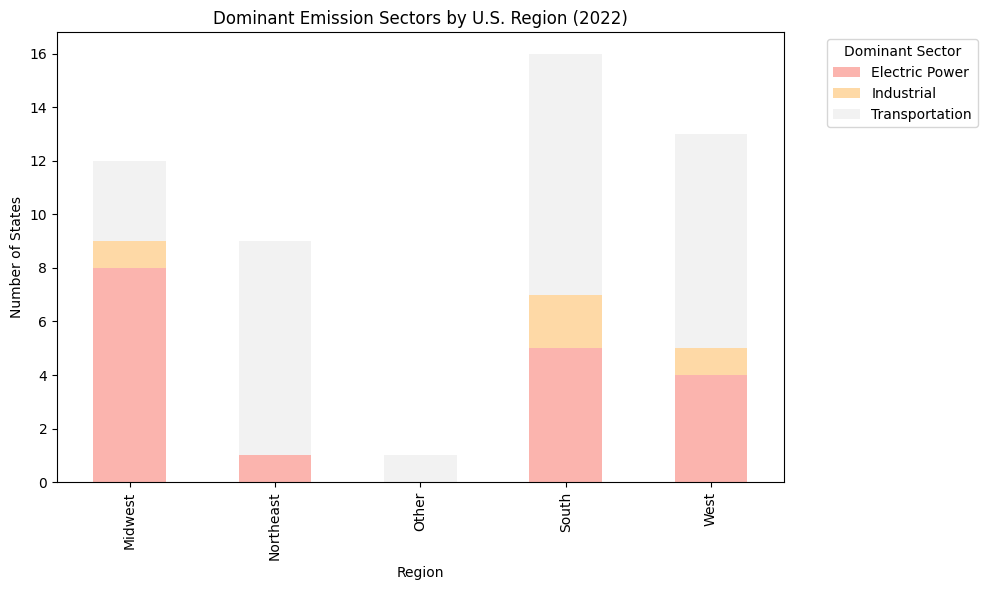

In [ ]:
# Create a simple U.S. region classification (approximate, can refine if needed)
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont',
             'New Jersey', 'New York', 'Pennsylvania']
midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
south = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia',
         'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
west = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming',
        'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

def classify_region(state):
    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

# Assign region
df2['Region'] = df2['State'].apply(classify_region)

# Create crosstab: Region vs Dominant Sector
region_sector_ct = pd.crosstab(df2['Region'], df2['Dominant Sector'])

# Plot as stacked bar chart
region_sector_ct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Pastel1')
plt.title('Dominant Emission Sectors by U.S. Region (2022)')
plt.xlabel('Region')
plt.ylabel('Number of States')
plt.legend(title='Dominant Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

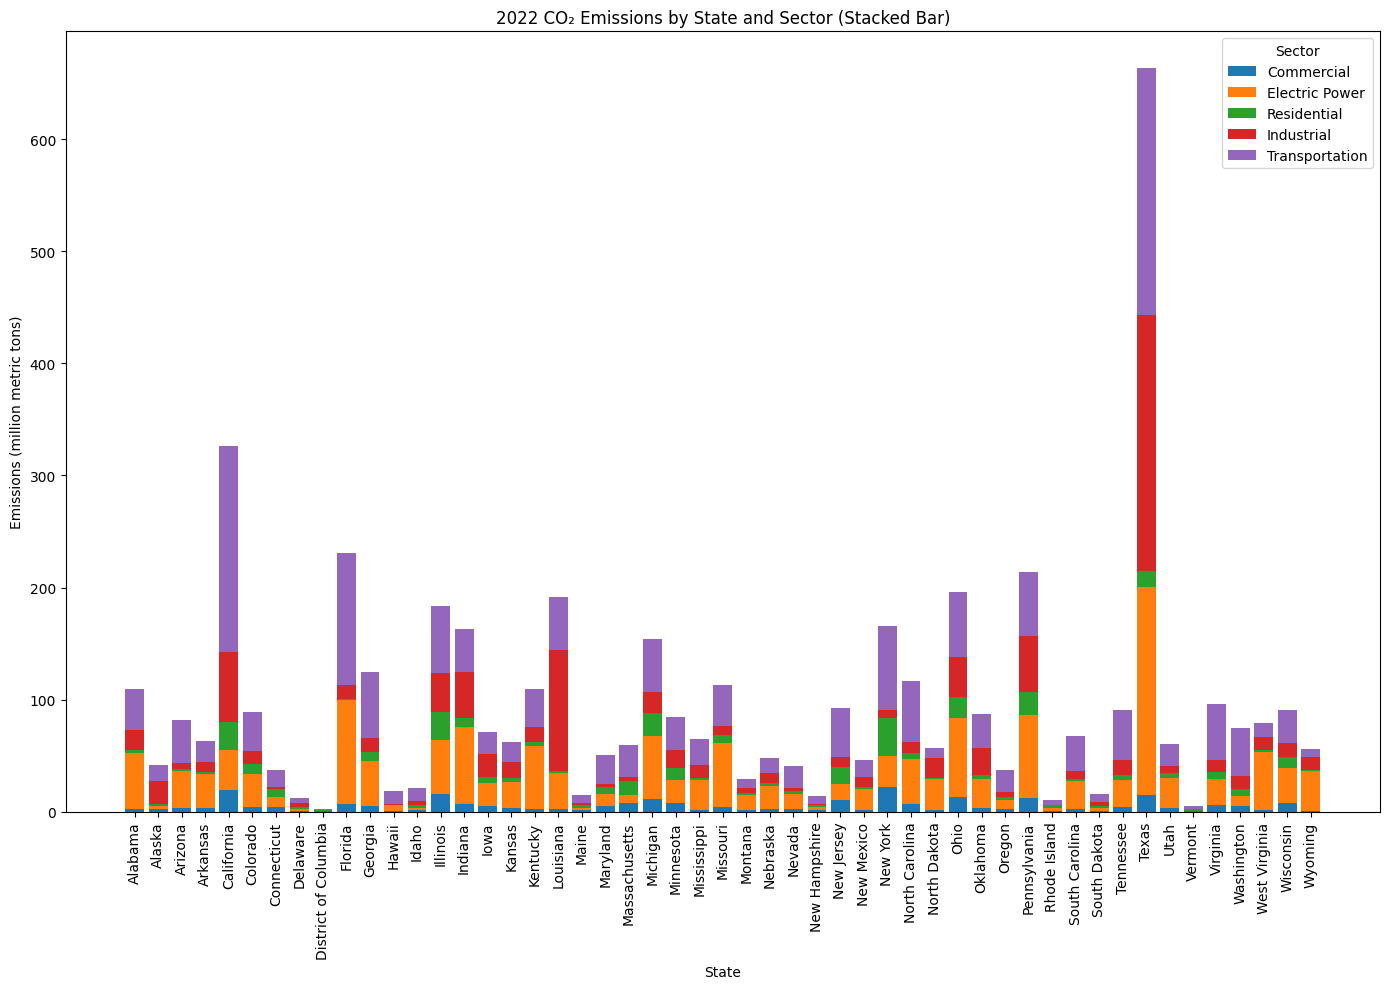

In [ ]:
# Convert relevant columns to numeric
for col in ['Commercial', 'Electric Power', 'Residential', 'Industrial', 'Transportation']:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Plot stacked bar
plt.figure(figsize=(14, 10))
bottom = np.zeros(len(df2))
for sector in ['Commercial', 'Electric Power', 'Residential', 'Industrial', 'Transportation']:
    plt.bar(df2['State'], df2[sector], bottom=bottom, label=sector)
    bottom += df2[sector].fillna(0)

plt.xticks(rotation=90)
plt.title('2022 CO₂ Emissions by State and Sector (Stacked Bar)')
plt.ylabel('Emissions (million metric tons)')
plt.xlabel('State')
plt.legend(title='Sector')
plt.tight_layout()
plt.show()

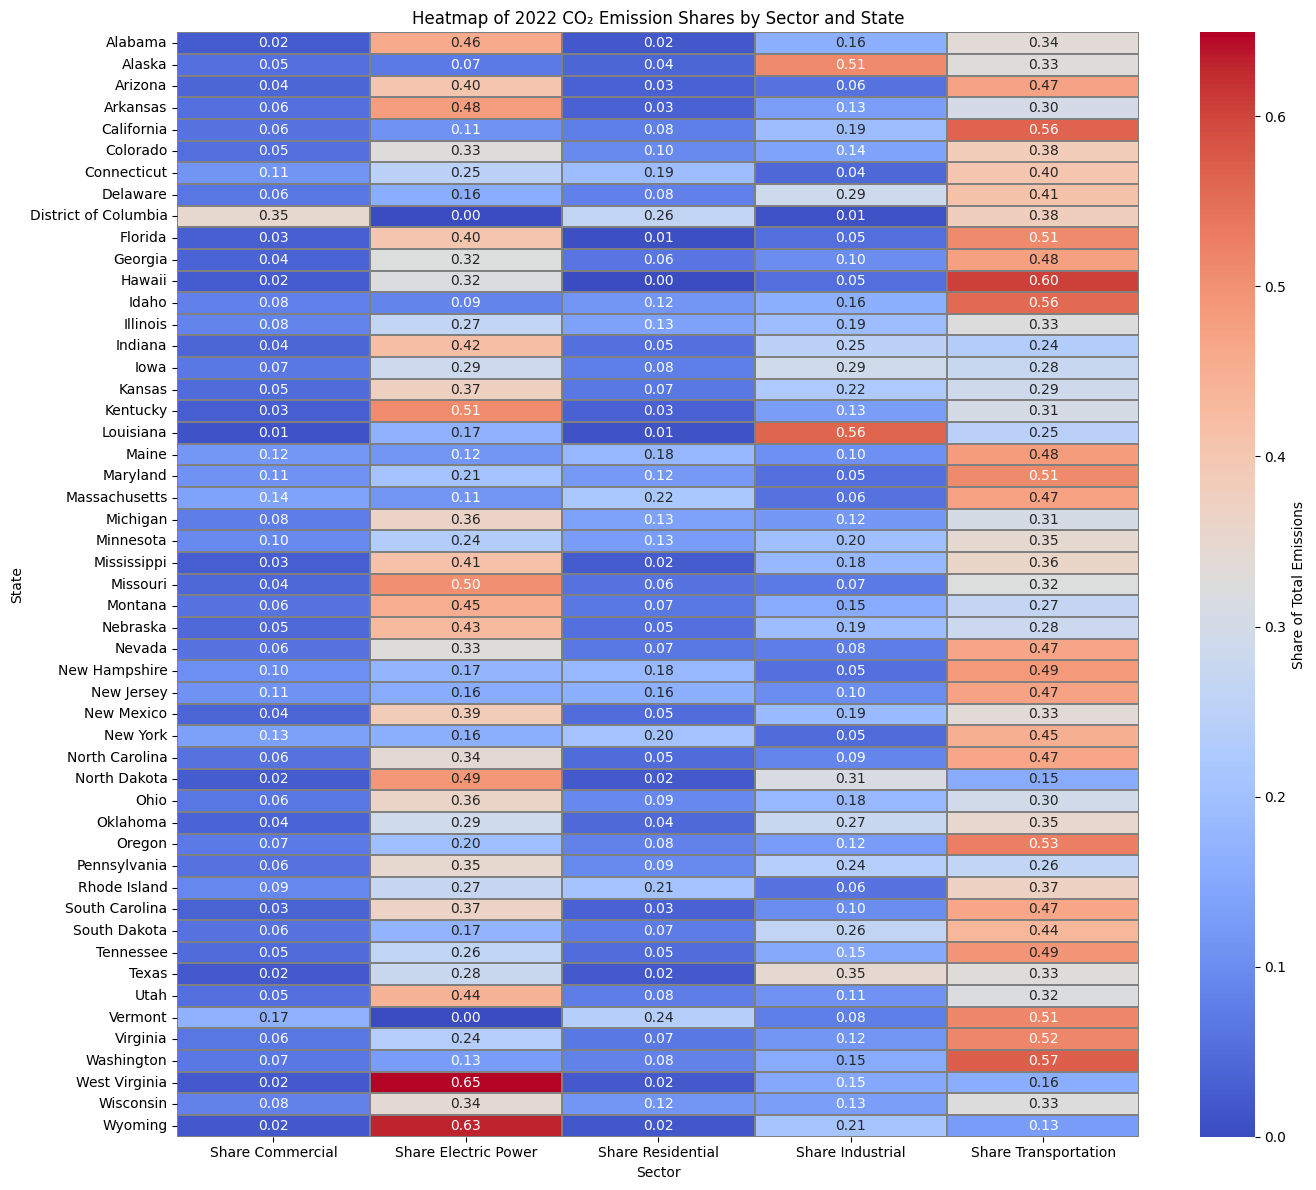

In [ ]:
# Convert sector share columns to numeric
share_cols = ['Share Commercial', 'Share Electric Power', 'Share Residential', 'Share Industrial', 'Share Transportation']
for col in share_cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Create a new DataFrame for the heatmap
heatmap_shares = df2.set_index('State')[share_cols]

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_shares, cmap="coolwarm", linewidths=0.3, linecolor='gray', annot=True, fmt=".2f", cbar_kws={'label': 'Share of Total Emissions'})
plt.title('Heatmap of 2022 CO₂ Emission Shares by Sector and State')
plt.xlabel('Sector')
plt.ylabel('State')
plt.tight_layout()
plt.show()

In [ ]:
df3 = pd.read_csv('/content/Electricity_Sales_by_State__2022_2023.csv')

<ipython-input-13-00a2c7884676>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(sector_totals_2022.keys()), y=list(sector_totals_2022.values()), palette='Blues_d')


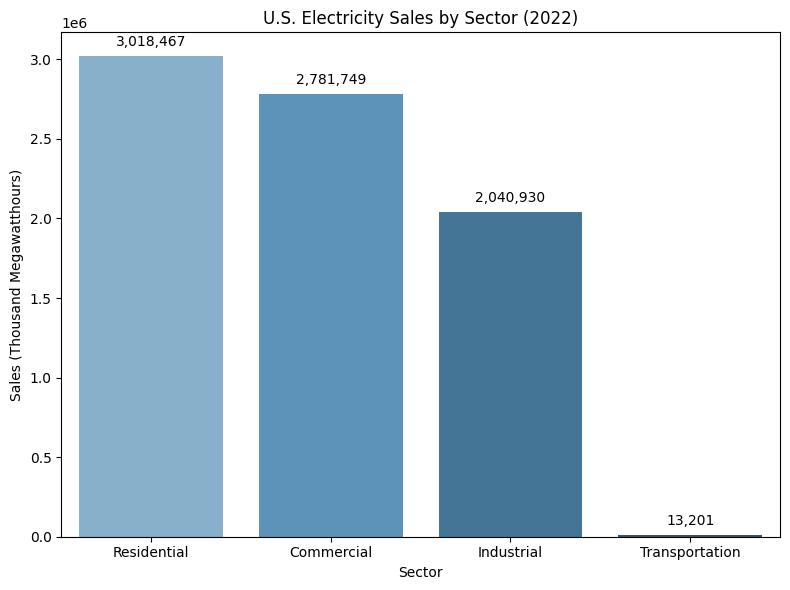

In [ ]:
# Calculate total 2022 sales by sector across all states
sector_totals_2022 = {
    'Residential': df3['Res_2022'].sum(),
    'Commercial': df3['Com_2022'].sum(),
    'Industrial': df3['Ind_2022'].sum(),
    'Transportation': df3['Trans_2022'].sum()
}

# Plot with actual sales values annotated on the bars
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=list(sector_totals_2022.keys()), y=list(sector_totals_2022.values()), palette='Blues_d')

# Annotate actual values on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.title('U.S. Electricity Sales by Sector (2022)')
plt.ylabel('Sales (Thousand Megawatthours)')
plt.xlabel('Sector')
plt.tight_layout()
plt.show()

In [ ]:
df_coal = pd.read_excel('coal.xlsx', skiprows = 3)

In [ ]:
cleaned_coal = df_coal.copy()
cleaned_coal.columns = cleaned_coal.iloc[0]
cleaned_coal = cleaned_coal[1:].reset_index(drop=True)
cleaned_coal = cleaned_coal.iloc[:-3].reset_index(drop=True)
cleaned_coal = cleaned_coal.iloc[:, :-4]
cleaned_coal = cleaned_coal[cleaned_coal['State'] != 'State total']
cleaned_coal.head()

,State,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
0,Alabama,63.266882,58.679185,62.782935,64.649415,61.367551,60.113988,59.376517,59.228493,54.367046,...,53.796310,54.814851,47.114372,39.057267,36.088898,35.940634,30.221573,24.496869,29.592888,28.450465
1,Alaska,1.247971,1.339161,1.209571,1.259627,1.184119,1.447701,1.299476,0.973314,0.446033,...,1.410527,1.735286,1.862277,1.586142,1.566262,1.657407,1.685702,1.776757,1.791877,1.784848
2,Arizona,0.820104,0.844128,0.715386,0.944069,4.599471,8.791837,13.308571,17.097755,15.211823,...,43.445247,42.758943,36.879344,30.947171,31.987903,31.711413,24.645335,15.019472,15.357593,14.754718
3,Arkansas,0.000000,0.004782,0.004759,0.214065,0.252240,0.081570,0.338631,0.496309,2.168674,...,31.241191,32.386388,21.687157,23.547345,25.588470,29.095380,22.930961,15.513457,20.706391,20.284936
4,California,5.637312,4.643315,4.318693,6.093154,5.528737,5.160331,6.124540,6.929989,6.275763,...,3.630020,3.759396,2.952192,3.061530,3.216609,3.180189,2.952396,2.685907,2.702959,2.875700


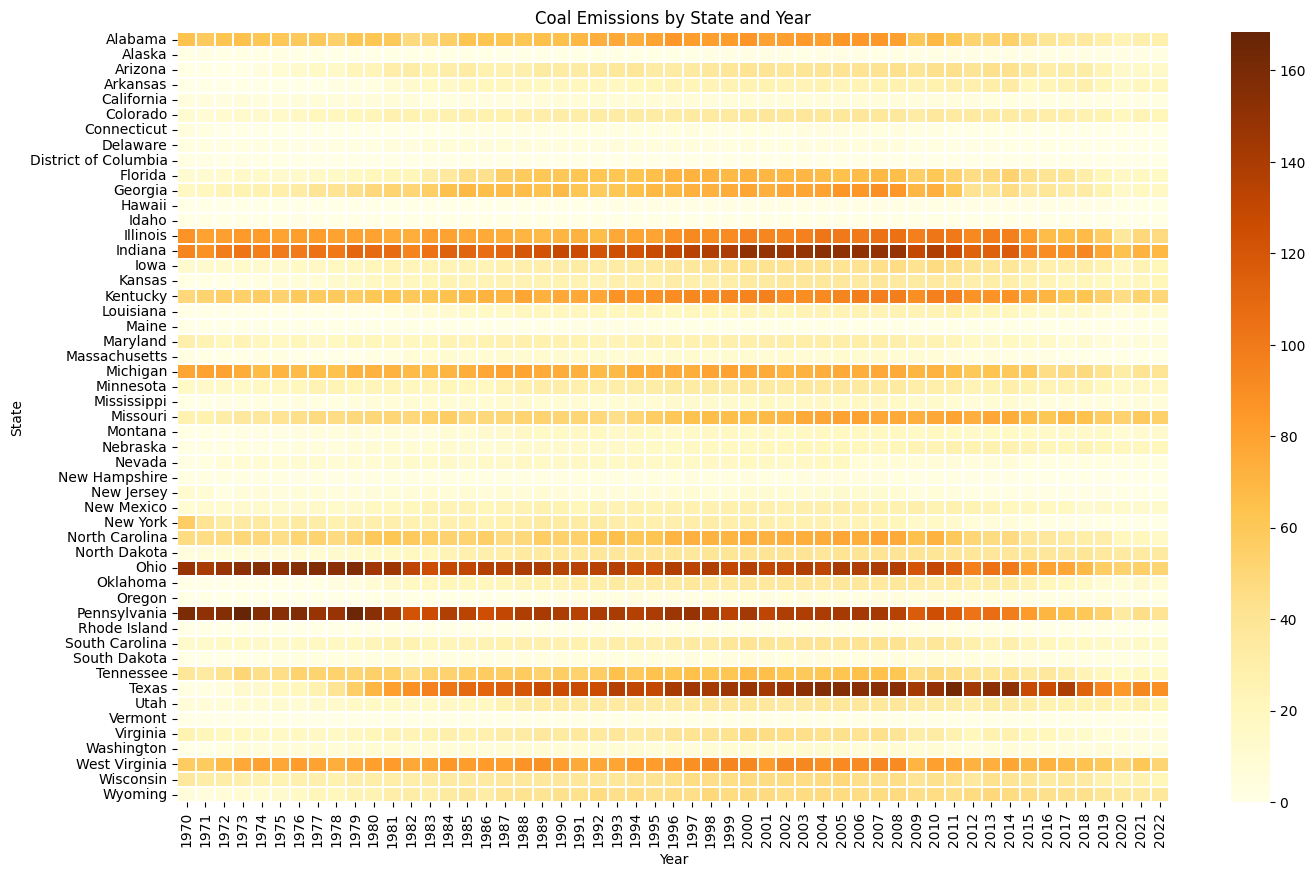

In [ ]:
coal_heat_map = cleaned_coal.set_index('State')
coal_heat_map.columns = coal_heat_map.columns.astype(int)
plt.figure(figsize=(16, 10))
sns.heatmap(coal_heat_map, cmap='YlOrBr', linewidths=0.3)
plt.title('Coal Emissions by State and Year')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

In [ ]:
df_petrol = pd.read_excel('petroleum.xlsx', skiprows = 3)
df_petrol.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,(1970-2022),Unnamed: 55,(2021-2022),Unnamed: 57
0,State,1970.000000,1971.000000,1972.000000,1973.000000,1974.000000,1975.000000,1976.000000,1977.000000,1978.000000,...,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,Percent,Absolute,Percent,Absolute
1,Alabama,23.454360,24.512072,27.290766,30.423031,32.787723,33.596781,36.635080,39.555298,39.559036,...,36.428719,35.700869,36.526814,36.168985,40.136209,39.706701,0.692935,16.252341,-0.010701,-0.429508
2,Alaska,6.750994,7.734127,8.299434,7.923612,8.311338,8.655103,9.967818,10.937319,11.564336,...,14.479130,15.064056,14.949233,15.029163,17.731769,17.194056,1.546892,10.443062,-0.030325,-0.537713
3,Arizona,13.392493,14.327025,16.866401,21.665881,21.431793,20.840199,21.048920,24.171485,24.305865,...,40.358585,40.789086,41.888558,37.531901,41.660651,41.953686,2.132627,28.561193,0.007034,0.293035
4,Arkansas,16.202431,17.666687,20.675133,23.655551,23.841447,22.925256,25.670630,29.017329,28.798179,...,21.672810,22.193285,22.446022,21.398944,22.191435,22.101844,0.364107,5.899414,-0.004037,-0.08959


In [ ]:
cleaned_petrol = df_petrol.copy()
cleaned_petrol.columns = cleaned_petrol.iloc[0]
cleaned_petrol = cleaned_petrol[1:].reset_index(drop=True)
cleaned_petrol = cleaned_petrol.iloc[:-3].reset_index(drop=True)
cleaned_petrol = cleaned_petrol.iloc[:, :-4]
cleaned_petrol = cleaned_petrol[cleaned_petrol['State'] != 'State total']
cleaned_petrol.head()

,State,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
0,Alabama,23.454360,24.512072,27.290766,30.423031,32.787723,33.596781,36.635080,39.555298,39.559036,...,33.607241,33.499132,35.048759,37.011322,36.428719,35.700869,36.526814,36.168985,40.136209,39.706701
1,Alaska,6.750994,7.734127,8.299434,7.923612,8.311338,8.655103,9.967818,10.937319,11.564336,...,15.502673,15.238473,16.003427,14.819612,14.479130,15.064056,14.949233,15.029163,17.731769,17.194056
2,Arizona,13.392493,14.327025,16.866401,21.665881,21.431793,20.840199,21.048920,24.171485,24.305865,...,37.553673,37.553541,38.436970,39.677660,40.358585,40.789086,41.888558,37.531901,41.660651,41.953686
3,Arkansas,16.202431,17.666687,20.675133,23.655551,23.841447,22.925256,25.670630,29.017329,28.798179,...,21.946076,22.031872,21.593417,21.731434,21.672810,22.193285,22.446022,21.398944,22.191435,22.101844
4,California,171.564226,182.714036,187.871103,210.614573,197.859505,205.117040,224.104785,250.106186,252.726700,...,215.052123,214.476223,222.489498,231.016964,237.203989,238.460428,238.050917,187.059757,208.091745,212.179311


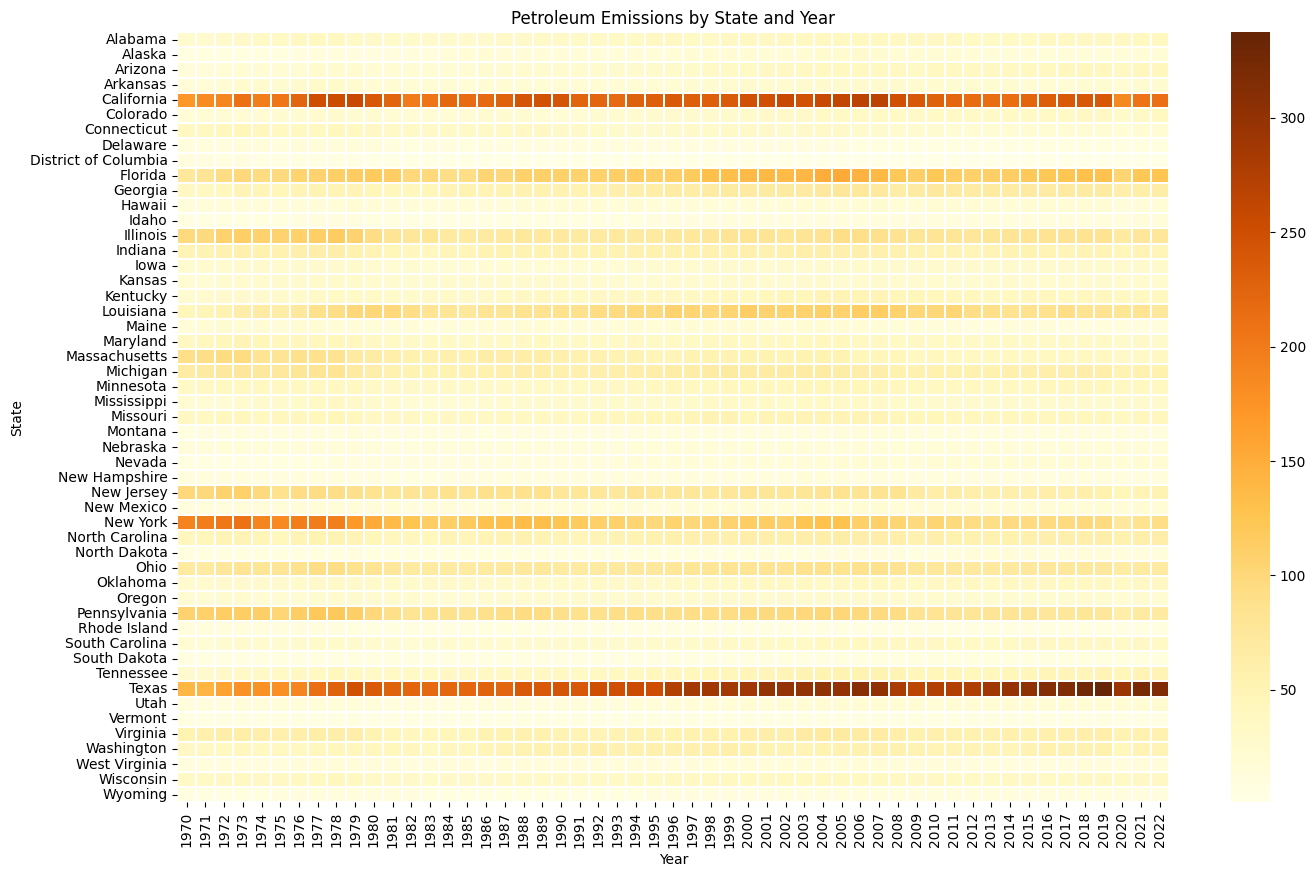

In [ ]:
petrol_heat_map = cleaned_petrol.set_index('State')
petrol_heat_map.columns = petrol_heat_map.columns.astype(int)
plt.figure(figsize=(16, 10))
sns.heatmap(petrol_heat_map, cmap='YlOrBr', linewidths=0.3)
plt.title('Petroleum Emissions by State and Year')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

In [ ]:
df_gas = pd.read_excel('natural_gas.xlsx', skiprows = 3)
df_gas.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,(1970-2022),Unnamed: 55,(2021-2022),Unnamed: 57
0,State,1970.000000,1971.000000,1972.000000,1973.000000,1974.000000,1975.000000,1976.000000,1977.000000,1978.000000,...,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,Percent,Absolute,Percent,Absolute
1,Alabama,15.996066,15.325146,14.911088,14.545628,14.676675,14.117123,12.111832,12.931593,12.739582,...,35.554489,40.265871,39.082824,37.311621,38.579953,41.133957,1.571505,25.137891,0.0662,2.554004
2,Alaska,3.360022,3.572927,3.926351,3.322771,3.298412,4.442474,4.724155,6.074154,7.520259,...,17.566652,17.671093,17.522600,19.109963,20.182635,22.325436,5.644431,18.965414,0.106171,2.142802
3,Arizona,10.725142,11.860453,12.675755,11.874292,10.741389,8.616499,9.449216,9.258910,9.792479,...,17.659842,21.147158,25.578270,27.127249,25.612843,24.718522,1.304727,13.99338,-0.034917,-0.894322
4,Arkansas,20.036061,17.475906,16.566618,17.034923,15.087395,13.410241,12.905391,12.184449,11.494230,...,16.561463,19.162549,19.401854,17.508361,18.829774,20.795761,0.037917,0.759701,0.104408,1.965988


In [ ]:
cleaned_gas = df_gas.copy()
cleaned_gas.columns = cleaned_gas.iloc[0]
cleaned_gas = cleaned_gas[1:].reset_index(drop=True)
cleaned_gas = cleaned_gas.iloc[:-3].reset_index(drop=True)
cleaned_gas = cleaned_gas.iloc[:, :-4]
cleaned_gas = cleaned_gas[cleaned_gas['State'] != 'State total']
cleaned_gas.head()

,State,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
0,Alabama,15.996066,15.325146,14.911088,14.545628,14.676675,14.117123,12.111832,12.931593,12.739582,...,32.727498,34.000279,36.648555,37.350010,35.554489,40.265871,39.082824,37.311621,38.579953,41.133957
1,Alaska,3.360022,3.572927,3.926351,3.322771,3.298412,4.442474,4.724155,6.074154,7.520259,...,17.048840,16.856502,17.069186,16.902251,17.566652,17.671093,17.522600,19.109963,20.182635,22.325436
2,Arizona,10.725142,11.860453,12.675755,11.874292,10.741389,8.616499,9.449216,9.258910,9.792479,...,17.995367,16.685880,19.280701,19.737522,17.659842,21.147158,25.578270,27.127249,25.612843,24.718522
3,Arkansas,20.036061,17.475906,16.566618,17.034923,15.087395,13.410241,12.905391,12.184449,11.494230,...,15.054710,14.245498,15.495334,16.486612,16.561463,19.162549,19.401854,17.508361,18.829774,20.795761
4,California,117.471291,118.771516,120.811879,112.828548,101.339669,101.437076,96.874812,97.638244,86.356465,...,129.611970,125.732146,124.218305,117.085573,114.051441,115.040175,115.509885,112.217336,113.284841,111.150350


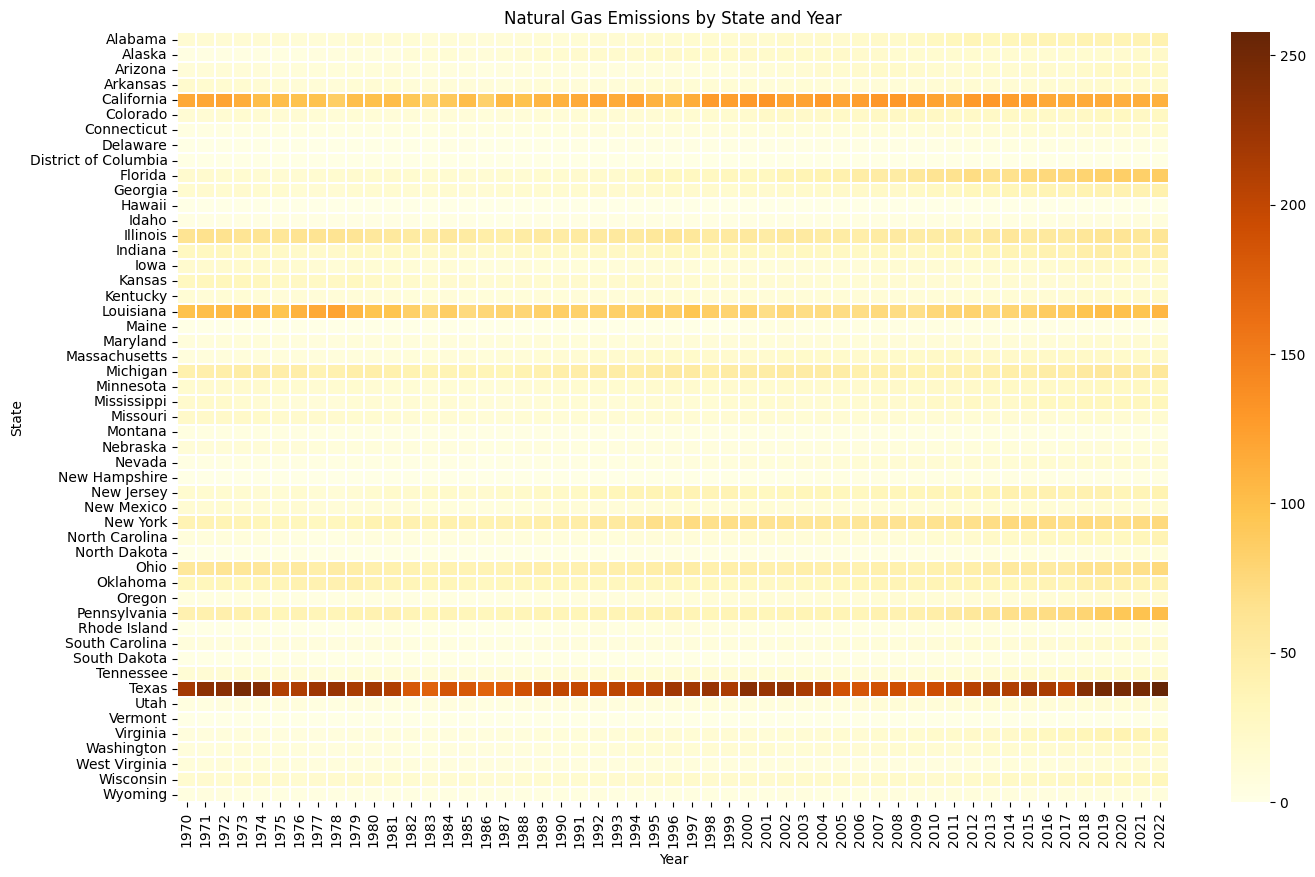

In [ ]:
gas_heat_map = cleaned_gas.set_index('State')
gas_heat_map.columns = gas_heat_map.columns.astype(int)
plt.figure(figsize=(16, 10))
sns.heatmap(gas_heat_map, cmap='YlOrBr', linewidths=0.3)
plt.title('Natural Gas Emissions by State and Year')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

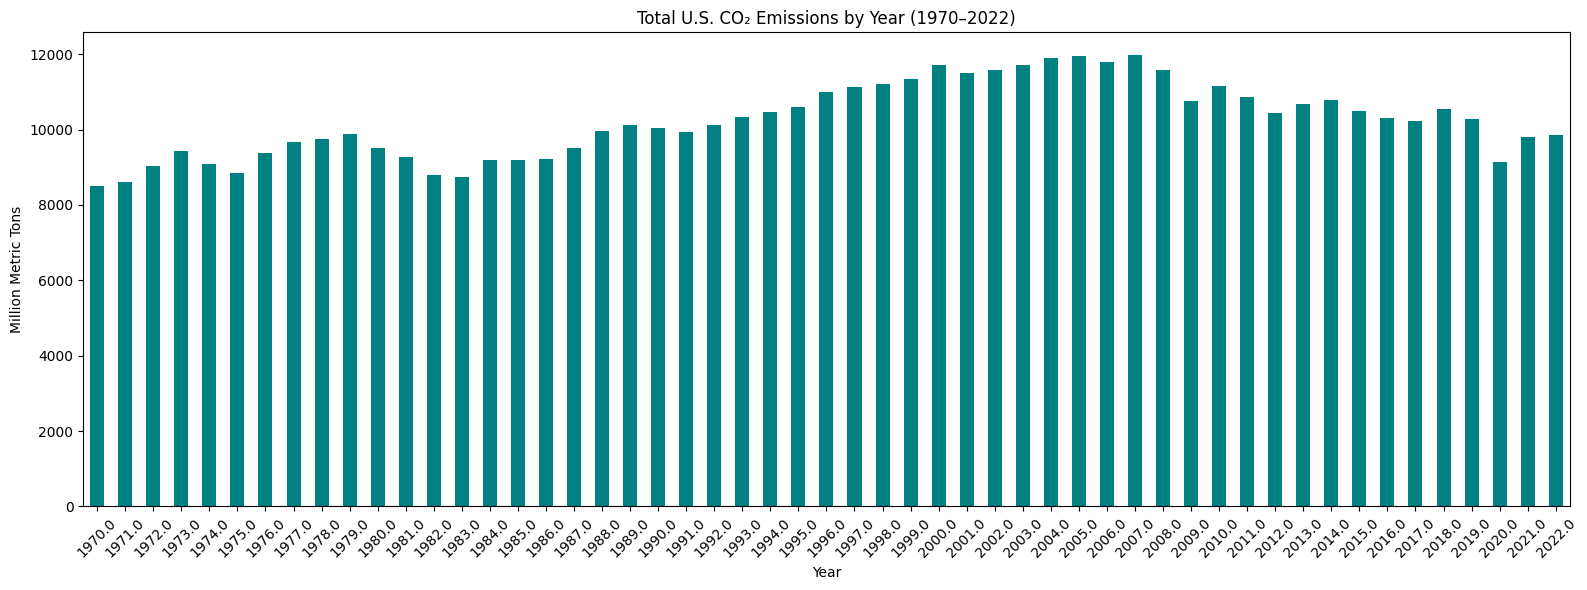

In [ ]:
# Reload the Excel file
file_path = "table1.xlsx"
excel_data = pd.read_excel(file_path)

# Load and clean the data
df = pd.read_excel("table1.xlsx", sheet_name="Table 1")
df.columns = df.iloc[3]
df = df.drop(index=[0, 1, 2, 3]).reset_index(drop=True)
df.rename(columns={df.columns[0]: 'State'}, inplace=True)

# Prepare emissions data
df.columns = df.columns.astype(str)
years = [col for col in df.columns if col.replace('.', '', 1).isdigit()]
heatmap_data = df.set_index('State')[years].astype(float)

# Plot 1: Total U.S. CO₂ emissions per year
total_emissions_by_year = heatmap_data.sum(axis=0)
plt.figure(figsize=(16, 6))
total_emissions_by_year.plot(kind='bar', color='teal')
plt.title("Total U.S. CO₂ Emissions by Year (1970–2022)")
plt.ylabel("Million Metric Tons")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DAG

In [ ]:
dag = Digraph()

# Define nodes
dag.node('T', 'HighBaseline CO2 (Treatment)', color='lightblue', style='filled')
dag.node('Y', 'Reduction Rate (Outcome)', color='gold', style='filled')
dag.node('R', 'Geographical Region', color='lightgreen', style='filled')
dag.node('S', 'Energy Use Sector Share', color='lightgreen', style='filled')
dag.node('E', 'Energy Source Emission', color='lightgreen', style='filled')
dag.node('P', 'Population', color='lightgreen', style='filled')
dag.node('C', 'Electricity Use', color='lightgreen', style='filled')
dag.node('Time', 'Year', color='lightgreen', style='filled')
dag.node('Price', 'Electricity Price', color='lightgreen', style='filled')
dag.node('GDP', 'GDP', color='pink', style='filled')
dag.node('AQI', 'AQI', color='pink', style='filled')
dag.node('Policy', 'Policy Interventions', color='lightgreen', style='filled')

# Define edges
dag.edge('R', 'P')
dag.edge('E', 'Y')
dag.edge('E', 'T')
dag.edge('C', 'E')
dag.edge('C', 'Y')
dag.edge('Policy', 'C')
dag.edge('Policy', 'S')
dag.edge('Policy', 'P')
dag.edge('S', 'E')
dag.edge('P', 'S')
dag.edge('P', 'E')
dag.edge('P', 'C')
dag.edge('P', 'T')
dag.edge('P', 'Y')
dag.edge('S', 'T')
dag.edge('S', 'Y')
dag.edge('Policy', 'Price')
dag.edge('Policy', 'Y')
dag.edge('Price', 'C')

dag.edge('T', 'GDP')
dag.edge('Y', 'GDP')
dag.edge('P', 'GDP')
dag.edge('GDP', 'C')
dag.edge('T', 'AQI')
dag.edge('Y', 'AQI')
dag.edge('R', 'Policy')
dag.edge('Time', 'Policy')

# Create a legend cluster
with dag.subgraph(name='cluster_legend') as legend:
    legend.attr(label='Legend', fontsize='12', style='dashed')
    legend.node('L1', 'Treatment', color='lightblue', style='filled')
    legend.node('L2', 'Outcome', color='gold', style='filled')
    legend.node('L3', 'Confounder', color='lightgreen', style='filled')
    legend.node('L4', 'Collider', color='pink', style='filled')
    # legend.node('L5', 'Mediator', color='grey', style='filled')
     # Force vertical stacking using invisible edges
    legend.edge('L1', 'L2', style='invis')
    legend.edge('L2', 'L3', style='invis')
    legend.edge('L3', 'L4', style='invis')
    # legend.edge('L4', 'L5', style='invis')


dag.render('causal_dag', format='png', view=True)

'causal_dag.png'

## Sector Data Cleaning

In [ ]:
# Map of state abbreviations to full names
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
    'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

In [ ]:
sector_data = pd.ExcelFile("use_tot_sector.xlsx")
sheets = ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector']

# Remove any rows where the state is 'US' or equivalent summary value

# Load and clean each sector sheet into a dict
sector_dfs = {}
for sheet in sheets:
    df = pd.read_excel(sector_data, sheet_name=sheet, skiprows=2)
    df = df.rename(columns={df.columns[0]: "State"})
    df = df[df['State'].notna()]  # Remove NaN rows
    df = df.loc[:, df.columns.notna()]  # Drop columns with no name
    df['State'] = df['State'].str.strip()
    df = df[~df['State'].str.upper().isin(['US', 'UNITED STATES'])]  # Remove US summary rows
    sector_dfs[sheet] = df

# Merge all sector dataframes on State and Year
# We'll melt each to long format: State, Year, Value, SectorName
sector_long = []
for name, df in sector_dfs.items():
    value_vars = [col for col in df.columns if col not in ['State', 'MSN', 'Description', 'Unit']]
    melted = df.melt(id_vars='State', value_vars=value_vars, var_name='Year', value_name='Value')
    melted['Sector'] = name.replace(' sector', '')
    sector_long.append(melted)
# Combine all melted sector dataframes into one
df_sector_long = pd.concat(sector_long, ignore_index=True)

In [ ]:
# Combine all sectors and pivot to panel format
df_panel_sector = df_sector_long.pivot_table(index=['State', 'Year'], columns='Sector', values='Value').reset_index()
df_panel_sector

Sector,State,Year,Commercial,Industrial,Residential,Transportation
0,AK,1960,6592.0,16472.0,9100.0,27139.0
1,AK,1961,6976.0,21444.0,9705.0,31895.0
2,AK,1962,7129.0,24859.0,10472.0,34182.0
3,AK,1963,9246.0,25598.0,11256.0,32387.0
4,AK,1964,12021.0,25522.0,13004.0,32246.0
...,...,...,...,...,...,...
3208,WY,2018,56716.0,324086.0,49658.0,115899.0
3209,WY,2019,54714.0,311549.0,51799.0,116170.0
3210,WY,2020,50706.0,279347.0,48795.0,107119.0
3211,WY,2021,50203.0,276379.0,47711.0,108872.0


In [ ]:
# Compute total energy use per row
df_panel_sector['Total'] = df_panel_sector[['Residential', 'Commercial', 'Industrial', 'Transportation']].sum(axis=1)

# Compute sector shares
for col in ['Residential', 'Commercial', 'Industrial', 'Transportation']:
    df_panel_sector[f'{col}_share'] = df_panel_sector[col] / df_panel_sector['Total']
df_panel_sector = df_panel_sector[df_panel_sector['Year'] >= 1970]
df_panel_sector['State'] = df_panel_sector['State'].map(state_abbrev_to_name)
# Rename columns in df_panel_sector to include appropriate units
df_panel_sector = df_panel_sector.rename(columns={
    'Residential': 'Residential_Energy_BBTU',
    'Commercial': 'Commercial_Energy_BBTU',
    'Industrial': 'Industrial_Energy_BBTU',
    'Transportation': 'Transportation_Energy_BBTU',
    'Total': 'Total_Energy_BBTU',
    'Residential_share': 'Residential_Energy_Share',
    'Commercial_share': 'Commercial_Energy_Share',
    'Industrial_share': 'Industrial_Energy_Share',
    'Transportation_share': 'Transportation_Energy_Share'
})

df_panel_sector

<ipython-input-33-a731f82407b5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_sector['State'] = df_panel_sector['State'].map(state_abbrev_to_name)


Sector,State,Year,Commercial_Energy_BBTU,Industrial_Energy_BBTU,Residential_Energy_BBTU,Transportation_Energy_BBTU,Total_Energy_BBTU,Residential_Energy_Share,Commercial_Energy_Share,Industrial_Energy_Share,Transportation_Energy_Share
10,Alaska,1970,28705.0,50729.0,23650.0,76386.0,179470.0,0.131777,0.159943,0.282660,0.425620
11,Alaska,1971,31762.0,53265.0,28350.0,85018.0,198395.0,0.142897,0.160095,0.268480,0.428529
12,Alaska,1972,36289.0,63913.0,28337.0,83425.0,211964.0,0.133688,0.171204,0.301528,0.393581
13,Alaska,1973,33124.0,62906.0,27583.0,71354.0,194967.0,0.141475,0.169895,0.322649,0.365980
14,Alaska,1974,34856.0,59470.0,28066.0,76803.0,199195.0,0.140897,0.174984,0.298552,0.385567
...,...,...,...,...,...,...,...,...,...,...,...
3208,Wyoming,2018,56716.0,324086.0,49658.0,115899.0,546359.0,0.090889,0.103807,0.593174,0.212130
3209,Wyoming,2019,54714.0,311549.0,51799.0,116170.0,534232.0,0.096960,0.102416,0.583172,0.217452
3210,Wyoming,2020,50706.0,279347.0,48795.0,107119.0,485967.0,0.100408,0.104340,0.574827,0.220424
3211,Wyoming,2021,50203.0,276379.0,47711.0,108872.0,483165.0,0.098747,0.103904,0.572018,0.225331


In [ ]:
df_panel_sector.to_csv('cleaned_sector.csv',index=False)

## Electricity Trade Index Data Cleaning

In [ ]:
electricity = pd.ExcelFile('/content/use_es_capita.xlsx')

# Load and clean both "Total" and "Residential" sheets in the same format as previous energy sector data
sheets_to_load = ['Total', 'Residential']
electricity_dfs = []

for sheet in sheets_to_load:
    df = pd.read_excel(electricity, sheet_name=sheet, skiprows=2)
    df = df.rename(columns={df.columns[0]: "State"})
    df = df[df['State'].notna()]
    df = df.loc[:, df.columns.notna()]
    df['State'] = df['State'].str.strip()
    df = df[~df['State'].str.upper().isin(['US', 'UNITED STATES'])]

    # Melt to long format
    year_cols = [col for col in df.columns if col != 'State']
    melted = df.melt(id_vars='State', value_vars=year_cols, var_name='Year', value_name='Value')
    melted['Category'] = sheet
    electricity_dfs.append(melted)

# Concatenate both sheets
df_electricity_long = pd.concat(electricity_dfs)

# Pivot to wide format: State, Year, Total, Residential
df_electricity_panel = df_electricity_long.pivot_table(index=['State', 'Year'], columns='Category', values='Value').reset_index()

# Convert Year to integer
df_electricity_panel['Year'] = df_electricity_panel['Year'].astype(int)

In [ ]:
df_electricity_panel = df_electricity_panel[df_electricity_panel['Year'] >= 1970]
df_electricity_panel['State'] = df_electricity_panel['State'].map(state_abbrev_to_name)
# Rename electricity panel columns to include units
df_electricity_panel = df_electricity_panel.rename(columns={
    'Residential': 'Residential_Electricity_MkWh',
    'Total': 'Total_Electricity_MkWh'
})
df_electricity_panel

<ipython-input-36-5d2416b40395>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electricity_panel['State'] = df_electricity_panel['State'].map(state_abbrev_to_name)


Category,State,Year,Residential_Electricity_MkWh,Total_Electricity_MkWh
10,Alaska,1970,527.0,1106.0
11,Alaska,1971,631.0,1299.0
12,Alaska,1972,628.0,1349.0
13,Alaska,1973,686.0,1502.0
14,Alaska,1974,754.0,1615.0
...,...,...,...,...
3208,Wyoming,2018,2748.0,16865.0
3209,Wyoming,2019,2849.0,16763.0
3210,Wyoming,2020,2880.0,15331.0
3211,Wyoming,2021,2897.0,15785.0


In [ ]:
df_electricity_panel.to_csv('cleaned_electricity.csv',index=False)

## Data Merging

In [ ]:
# Load all updated cleaned datasets
df_emissions = pd.read_csv("cleaned_emissions_and_region.csv")
df_population = pd.read_csv("cleaned_population.csv")
df_electricity = pd.read_csv("cleaned_electricity.csv")
df_sector = pd.read_csv("cleaned_sector.csv")
df_fuel = pd.read_csv("cleaned_emissions_by_fuel_type.csv")

# Merge all dataframes on ['State', 'Year']
merged_df = df_emissions.merge(df_population, on=['State', 'Year'], how='outer')
merged_df = merged_df.merge(df_electricity, on=['State', 'Year'], how='outer')
merged_df = merged_df.merge(df_sector, on=['State', 'Year'], how='outer')
merged_df = merged_df.merge(df_fuel, on=['State', 'Year'], how='outer')
merged_df = merged_df[merged_df['State'].notna()]

In [ ]:
merged_df

,State,Year,Emissions,Region,Population,Residential_Electricity_MkWh,Total_Electricity_MkWh,Commercial_Energy_BBTU,Industrial_Energy_BBTU,Residential_Energy_BBTU,Transportation_Energy_BBTU,Total_Energy_BBTU,Residential_Energy_Share,Commercial_Energy_Share,Industrial_Energy_Share,Transportation_Energy_Share,coal_emissions,petroleum_emissions,natural_gas_emissions
0,Alabama,1970,102.717308,South,"3,451",11527.0,34713.0,104587.0,769298.0,207031.0,268489.0,1349405.0,0.153424,0.077506,0.570102,0.198968,63.3,23.5,16.0
1,Alabama,1971,98.516403,South,"3,497",12237.0,35803.0,106981.0,738097.0,212394.0,281247.0,1338719.0,0.158655,0.079913,0.551346,0.210087,58.7,24.5,15.3
2,Alabama,1972,104.984789,South,"3,539",13348.0,39400.0,114157.0,792033.0,223573.0,300827.0,1430590.0,0.156280,0.079797,0.553641,0.210282,62.8,27.3,14.9
3,Alabama,1973,109.618074,South,"3,580",14704.0,42711.0,117343.0,796124.0,238217.0,327548.0,1479232.0,0.161041,0.079327,0.538201,0.221431,64.6,30.4,14.5
4,Alabama,1974,108.831948,South,"3,626",14687.0,43221.0,119155.0,789293.0,234102.0,350726.0,1493276.0,0.156771,0.079794,0.528565,0.234870,61.4,32.8,14.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,Wyoming,2018,63.639323,West,579,2748.0,16865.0,56716.0,324086.0,49658.0,115899.0,546359.0,0.090889,0.103807,0.593174,0.212130,43.6,11.0,9.0
2699,Wyoming,2019,58.897673,West,580,2849.0,16763.0,54714.0,311549.0,51799.0,116170.0,534232.0,0.096960,0.102416,0.583172,0.217452,39.2,10.8,8.8
2700,Wyoming,2020,55.385165,West,578,2880.0,15331.0,50706.0,279347.0,48795.0,107119.0,485967.0,0.100408,0.104340,0.574827,0.220424,37.2,9.6,8.6
2701,Wyoming,2021,54.413727,West,580,2897.0,15785.0,50203.0,276379.0,47711.0,108872.0,483165.0,0.098747,0.103904,0.572018,0.225331,36.1,10.0,8.3


In [ ]:
merged_df.to_csv('merged_df_q1.csv',index=False)

## Regression:

In [ ]:
df = pd.read_csv('merged_df_q1.csv')

# Clean 'Population': remove commas and convert to float
df['Population'] = df['Population'].replace(',', '', regex=True).astype(float)

# One-hot encode 'Region'
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

# Define treatment: 1 if state's 1970–75 avg CO2 emissions > median, else 0
baseline_avg = df[df['Year'].between(1970, 1975)].groupby('State')['Emissions'].mean()
median_baseline = baseline_avg.median()
df['treatment'] = df['State'].map(lambda x: 1 if baseline_avg[x] > median_baseline else 0)

# Define outcome: year-over-year reduction in emissions
df = df.sort_values(['State', 'Year'])
df['lag_emissions'] = df.groupby('State')['Emissions'].shift(1)
df['reduction_rate'] = (df['lag_emissions'] - df['Emissions']) / df['lag_emissions']
df = df.dropna()

# Now drop 'State' since we don't use it in regression
df = df.drop(columns=['State'])

# Feature list for regression
features = [
    'Population', 'Residential_Electricity_MkWh', 'Total_Electricity_MkWh',
    'Commercial_Energy_BBTU', 'Industrial_Energy_BBTU', 'Residential_Energy_BBTU',
    'Transportation_Energy_BBTU', 'Total_Energy_BBTU',
    'Residential_Energy_pct', 'Commercial_Energy_pct', 'Industrial_Energy_pct',
    'Transportation_Energy_pct', 'coal_emissions', 'petroleum_emissions',
    'natural_gas_emissions'
]

df['Residential_Energy_pct'] = df['Residential_Energy_BBTU'] / df['Total_Energy_BBTU']
df['Commercial_Energy_pct'] = df['Commercial_Energy_BBTU'] / df['Total_Energy_BBTU']
df['Industrial_Energy_pct'] = df['Industrial_Energy_BBTU'] / df['Total_Energy_BBTU']
df['Transportation_Energy_pct'] = df['Transportation_Energy_BBTU'] / df['Total_Energy_BBTU']
# Add encoded region dummies
region_dummies = [col for col in df.columns if col.startswith('Region_')]
encoded_features = features + region_dummies

X = df[['treatment'] + encoded_features].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df['reduction_rate'], errors='coerce')

# Drop any remaining missing values (just in case)
X = X.dropna()
y = y.loc[X.index]  # make sure y aligns with X



# Final conversion to float
X = X.astype(float)
y = y.astype(float)

# Regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         reduction_rate   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.300
Date:                Sun, 11 May 2025   Prob (F-statistic):           9.29e-15
Time:                        21:10:55   Log-Likelihood:                 3880.3
No. Observations:                2652   AIC:                            -7725.
Df Residuals:                    2634   BIC:                            -7619.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Analysis

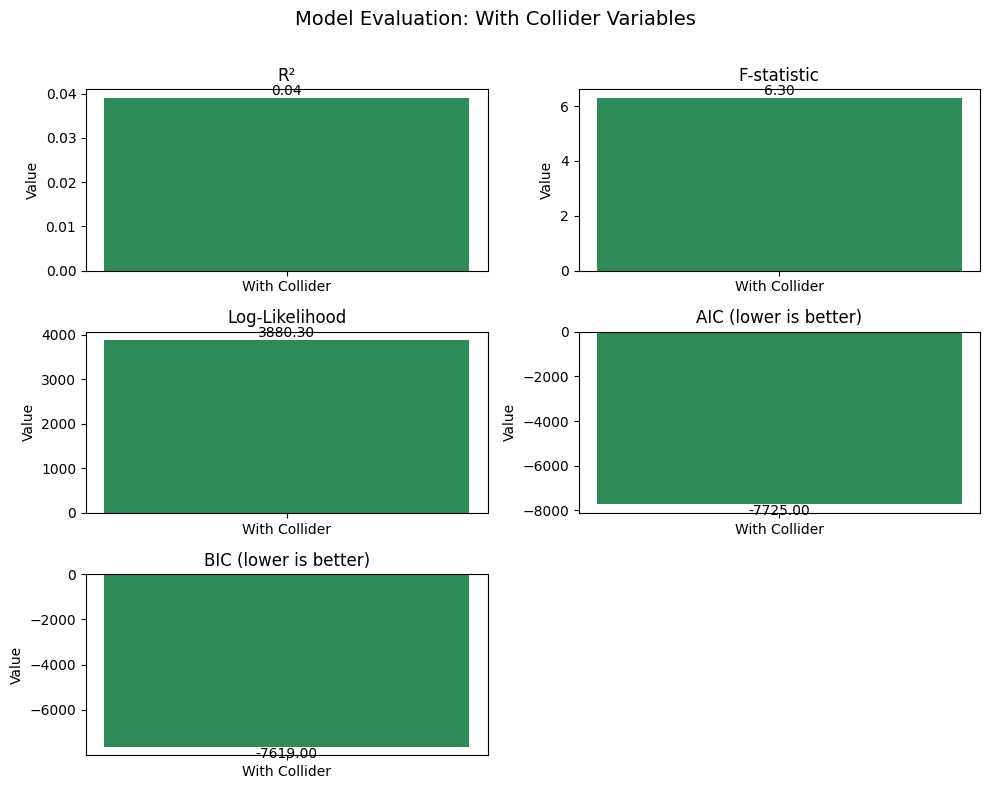

In [ ]:
# Model label
model = ['With Collider']

# Metrics from your regression output for the "With Collider" model
r_squared = [0.039]
f_statistic = [6.300]
log_likelihood = [3880.3]
aic = [-7725]
bic = [-7619]

# Combine metrics into a structure
metrics = {
    'R²': r_squared,
    'F-statistic': f_statistic,
    'Log-Likelihood': log_likelihood,
    'AIC (lower is better)': aic,
    'BIC (lower is better)': bic,
}

# Plotting
x = np.arange(len(model))
width = 0.4
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axs = axs.flatten()

for i, (metric, values) in enumerate(metrics.items()):
    ax = axs[i]
    bars = ax.bar(x, values, width, color='seagreen')
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.bar_label(bars, fmt='%.2f')
    ax.set_ylabel('Value')

# Remove unused subplot
fig.delaxes(axs[-1])

fig.suptitle('Model Evaluation: With Collider Variables', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Research Question #2 Other Green House Emission Data Cleaning

In [ ]:
df_ghg = pd.read_csv('AllStateGHGData90-22_v082924.csv')

<ipython-input-44-0c10a7d120bb>:1: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ghg = pd.read_csv('AllStateGHGData90-22_v082924.csv')


In [ ]:
df_ghg_long = df_ghg.melt(
    id_vars=['geo_ref', 'ghg_category'],
    value_vars=[col for col in df_ghg.columns if col.startswith('Y')],
    var_name='Year',
    value_name='Emissions_Tg'
)

# Clean and convert year
df_ghg_long['Year'] = df_ghg_long['Year'].str.replace('Y', '').astype(int)

# Ensure emissions are numeric
df_ghg_long['Emissions_Tg'] = pd.to_numeric(df_ghg_long['Emissions_Tg'], errors='coerce')

# Group by state, year, and gas, and sum across all sectors
df_ghg_summary = df_ghg_long.groupby(['geo_ref', 'Year', 'ghg_category'])['Emissions_Tg'].sum().reset_index()
df_ghg_summary

,geo_ref,Year,ghg_category,Emissions_Tg
0,AK,1990,CH4,6.344382
1,AK,1990,CO2,22.648210
2,AK,1990,HFC,0.000552
3,AK,1990,N2O,2.118150
4,AK,1990,NF3,0.000000
...,...,...,...,...
13921,WY,2022,HFC,0.175156
13922,WY,2022,N2O,6.345639
13923,WY,2022,NF3,0.000000
13924,WY,2022,PFC,0.003553


In [ ]:
# Map of state abbreviations to full names
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
    'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

In [ ]:
df_ghg_summary['State'] = df_ghg_summary['geo_ref'].map(state_abbrev_to_name)
df_ghg_summary

,geo_ref,Year,ghg_category,Emissions_Tg,State
0,AK,1990,CH4,6.344382,Alaska
1,AK,1990,CO2,22.648210,Alaska
2,AK,1990,HFC,0.000552,Alaska
3,AK,1990,N2O,2.118150,Alaska
4,AK,1990,NF3,0.000000,Alaska
...,...,...,...,...,...
13921,WY,2022,HFC,0.175156,Wyoming
13922,WY,2022,N2O,6.345639,Wyoming
13923,WY,2022,NF3,0.000000,Wyoming
13924,WY,2022,PFC,0.003553,Wyoming


In [ ]:
df_ghg_pivot = df_ghg_summary.pivot_table(
    index=['State', 'Year'],
    columns='ghg_category',
    values='Emissions_Tg',
    aggfunc='sum'
).reset_index()
df_ghg_pivot = df_ghg_pivot.drop(columns=['CO2'])
df_ghg_pivot.head()

ghg_category,State,Year,CH4,HFC,N2O,NF3,PFC,SF6
0,Alabama,1990,31.655518,0.103069,4.439218,0.159938,2.795807,1.916527
1,Alabama,1991,30.470356,0.117518,4.734528,0.174664,3.009591,2.018221
2,Alabama,1992,28.946662,0.150890,4.722690,0.189390,3.223749,2.140795
3,Alabama,1993,26.451814,0.245231,4.811587,0.204117,3.314262,2.249508
4,Alabama,1994,28.721794,0.422494,5.169935,0.218843,3.528421,2.344062


1 Tg = million metric tons. So the unit is consistent despite different data sources.

## Merge with Q1 Data

In [ ]:
q1_df = pd.read_csv('/content/merged_df_q1.csv')

In [ ]:
merged = q1_df.merge(df_ghg_pivot, how='right', on=['State', 'Year'])
merged.head()

,State,Year,Emissions,Region,Population,Residential_Electricity_MkWh,Total_Electricity_MkWh,Commercial_Energy_BBTU,Industrial_Energy_BBTU,Residential_Energy_BBTU,...,Transportation_Energy_Share,coal_emissions,petroleum_emissions,natural_gas_emissions,CH4,HFC,N2O,NF3,PFC,SF6
0,Alabama,1990,109.751599,South,"4,050",20719.0,59926.0,158669.0,762066.0,280898.0,...,0.248713,64.6,32.1,13.0,31.655518,0.103069,4.439218,0.159938,2.795807,1.916527
1,Alabama,1991,114.055396,South,"4,099",21293.0,61227.0,155364.0,772671.0,284056.0,...,0.250970,68.7,31.9,13.5,30.470356,0.117518,4.734528,0.174664,3.009591,2.018221
2,Alabama,1992,120.975301,South,"4,154",21137.0,62167.0,153440.0,833437.0,287511.0,...,0.246758,73.6,32.6,14.8,28.946662,0.150890,4.722690,0.189390,3.223749,2.140795
3,Alabama,1993,125.285399,South,"4,214",22628.0,65058.0,157551.0,869494.0,304057.0,...,0.237075,76.9,32.9,15.6,26.451814,0.245231,4.811587,0.204117,3.314262,2.249508
4,Alabama,1994,123.209090,South,"4,260",23159.0,67581.0,160410.0,929432.0,300704.0,...,0.236941,73.1,34.7,15.4,28.721794,0.422494,5.169935,0.218843,3.528421,2.344062


In [ ]:
merged.to_csv('merged_df_q2.csv',index=False)

## Random Forest

In [ ]:
q2_df = pd.read_csv('merged_df_q2.csv')

In [ ]:
# Convert Population to numeric
q2_df['Population'] = q2_df['Population'].str.replace(',', '').astype(float)

# One-hot encode Region
q2_encoded = pd.get_dummies(q2_df, columns=['Region'], drop_first=True)

# Define features and target
X = q2_encoded.drop(columns=['State', 'Year', 'Emissions', 'coal_emissions', 'petroleum_emissions', 'natural_gas_emissions'])
y = q2_encoded['Emissions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(6.415230769375507), 0.995903756787535)

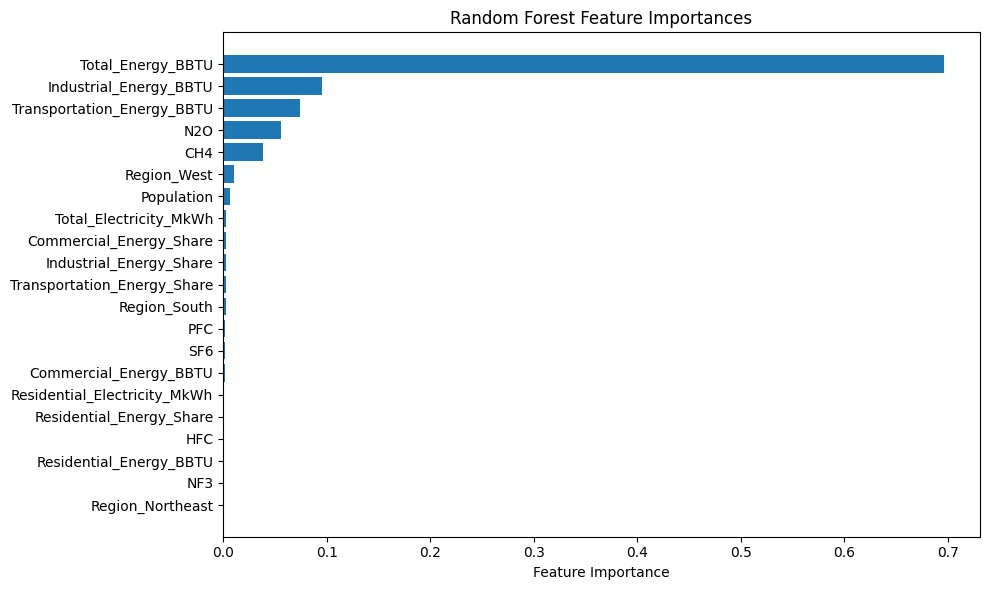

In [ ]:
# Cross-validation with 5 folds using negative mean squared error (neg_MSE), then convert to RMSE
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse = -cv_scores
# Cross-validation R² scores
cv_r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

# Feature importance
importances = rf_model.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# View individual and average R² values
cv_r2_scores, cv_r2_scores.mean()

(array([0.94244287, 0.51483806, 0.9164257 , 0.9313412 , 0.64775221]),
 np.float64(0.790560010755212))

In [ ]:
# Return cross-validation RMSE scores and mean
cv_rmse, cv_rmse.mean()

(array([ 25.09759429,  54.15110721,  13.54603892,  21.48604032,
        102.38066815]),
 np.float64(43.332289779984464))

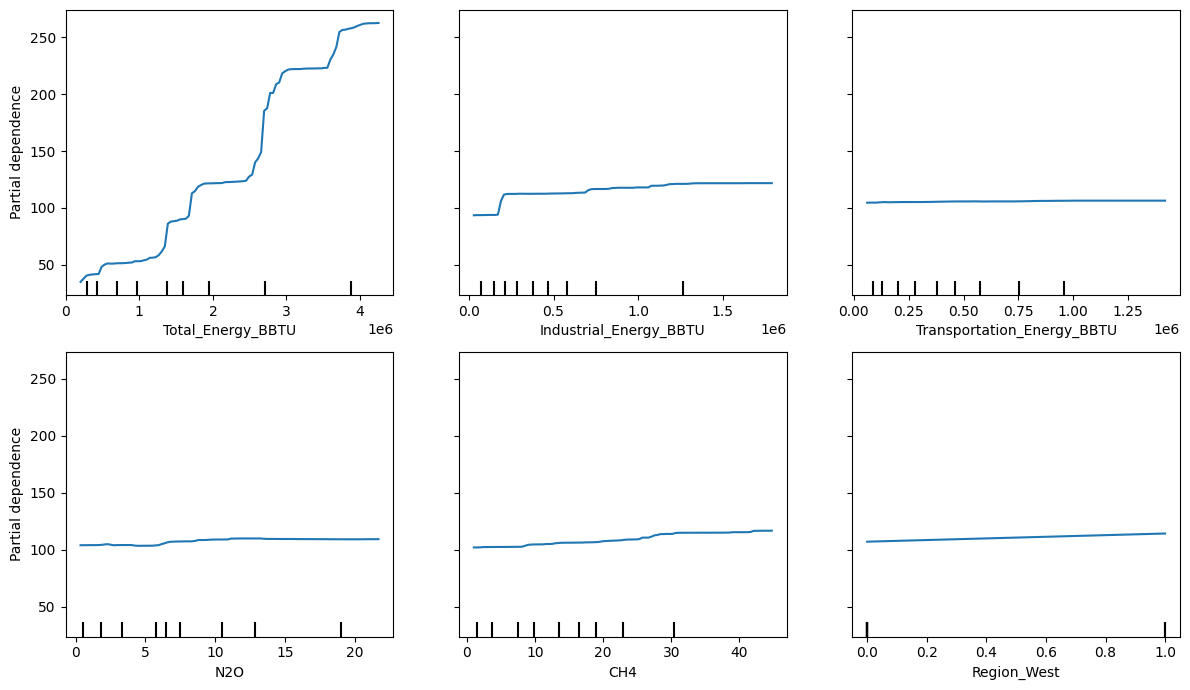

In [ ]:
# Plot partial dependence for top 2 features
top_features = [features[i] for i in sorted_indices[:6]]
# Create a larger grid layout with more space
fig, ax = plt.subplots(figsize=(12, 7))  # wider and taller figure
PartialDependenceDisplay.from_estimator(
    rf_model,
    X,
    features=top_features,
    n_cols=3,  # display plots in 3 columns
    ax=ax
)
plt.tight_layout()
plt.show()

## Parameter Grid Search

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Evaluate
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmse, r2

Fitting 5 folds for each of 48 candidates, totalling 240 fits


(np.float64(5.98174768992007), 0.9964386279262736)

In [ ]:
# Show only tuned hyperparameters
for param, value in best_rf.get_params().items():
    if param in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']:
        print(f"{param}: {value}")

max_depth: 20
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200


In [ ]:
# Cross-validation with 5 folds using negative mean squared error (neg_MSE), then convert to RMSE
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse = -cv_scores
# Cross-validation R² scores
cv_r2_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
cv_r2_scores, cv_r2_scores.mean()

(array([0.91688731, 0.90064176, 0.92259042, 0.91419895, 0.66503443]),
 np.float64(0.8638705754944688))

In [ ]:
cv_rmse, cv_rmse.mean()

(array([30.15894992, 24.50563323, 13.0368688 , 24.01898128, 99.83754754]),
 np.float64(38.31159615463963))

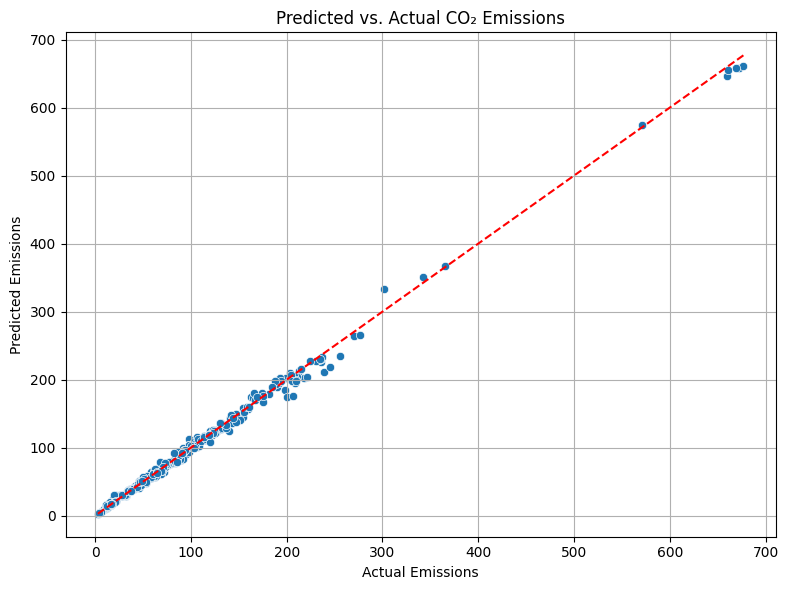

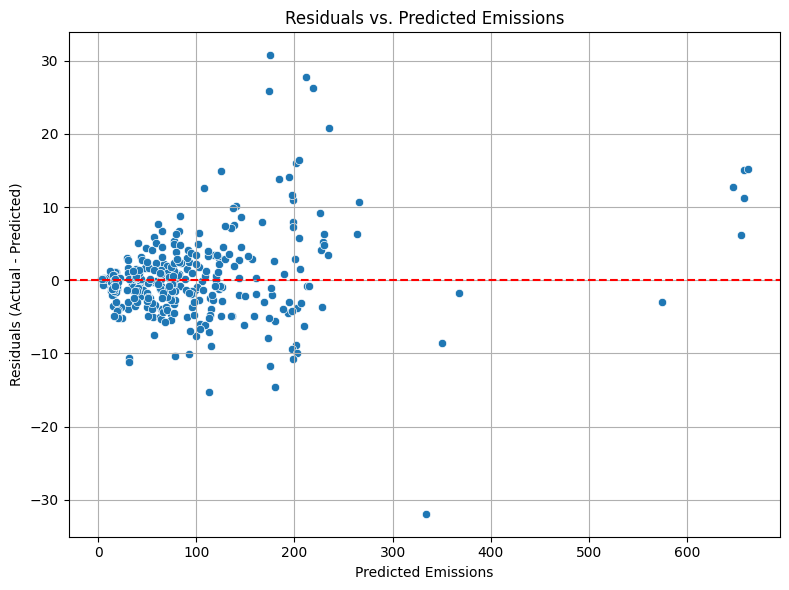

In [ ]:
# Plot 1: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Emissions')
plt.ylabel('Predicted Emissions')
plt.title('Predicted vs. Actual CO₂ Emissions')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Emissions')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Emissions')
plt.grid(True)
plt.tight_layout()
plt.show()

## Bayesial GLM Regression

In [ ]:
df = pd.read_csv('merged_df_q2.csv')


# Keep relevant columns
features = [
    'Population',
    'Total_Electricity_MkWh',
    'Total_Energy_BBTU',
    'Residential_Energy_Share',	'Commercial_Energy_Share',	'Industrial_Energy_Share',	'Transportation_Energy_Share',
    'CH4',	'HFC',	'N2O',	'NF3',	'PFC',	'SF6',
    'Year'
]
target = 'Emissions'

# Drop any rows with missing data
df = df[features + [target]].dropna()


# Clean string commas from numeric columns
for col in features:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target].astype(str).str.replace(',', '').astype(float).values

# Bayesian GLM with Gamma likelihood and log link
with pm.Model() as model:
    # Priors on coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)

    # Linear predictor (on log scale)
    eta = intercept + pm.math.dot(X, beta)
    mu = pm.math.exp(eta)  # log link

    # Gamma likelihood with mu + sigma
    sigma = pm.HalfCauchy("sigma", beta=1)
    y_obs = pm.Gamma("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9,
                  idata_kwargs={"log_likelihood": True})

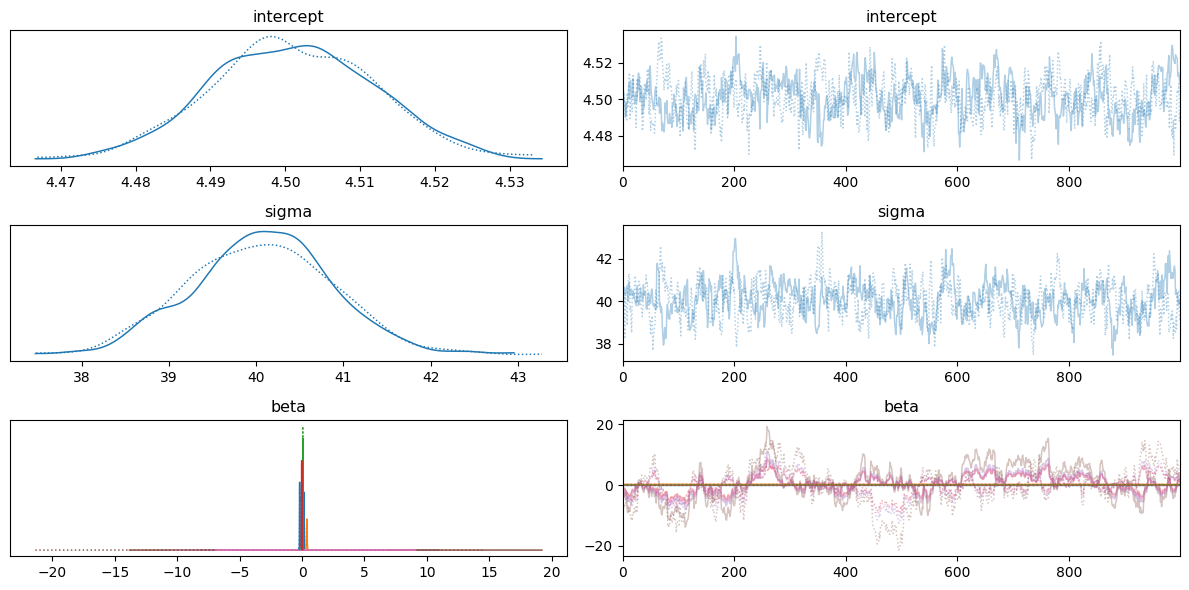

In [ ]:
# Posterior analysis
# ----------- Clean Trace Plot ------------
# Plot trace (unchanged)
az.plot_trace(trace, var_names=["intercept", "sigma", "beta"],
              compact=True, figsize=(12, 6))
plt.tight_layout()
plt.show()

                    Feature  Posterior Mean
     Total_Electricity_MkWh        0.375286
    Industrial_Energy_Share        0.174252
                 Population        0.146112
   Residential_Energy_Share        0.136097
                        SF6        0.063290
          Total_Energy_BBTU        0.027797
                        PFC        0.009921
                        HFC        0.005988
                        CH4       -0.010194
                        N2O       -0.018585
                       Year       -0.028577
    Commercial_Energy_Share       -0.073554
Transportation_Energy_Share       -0.100454
                        NF3       -0.189215


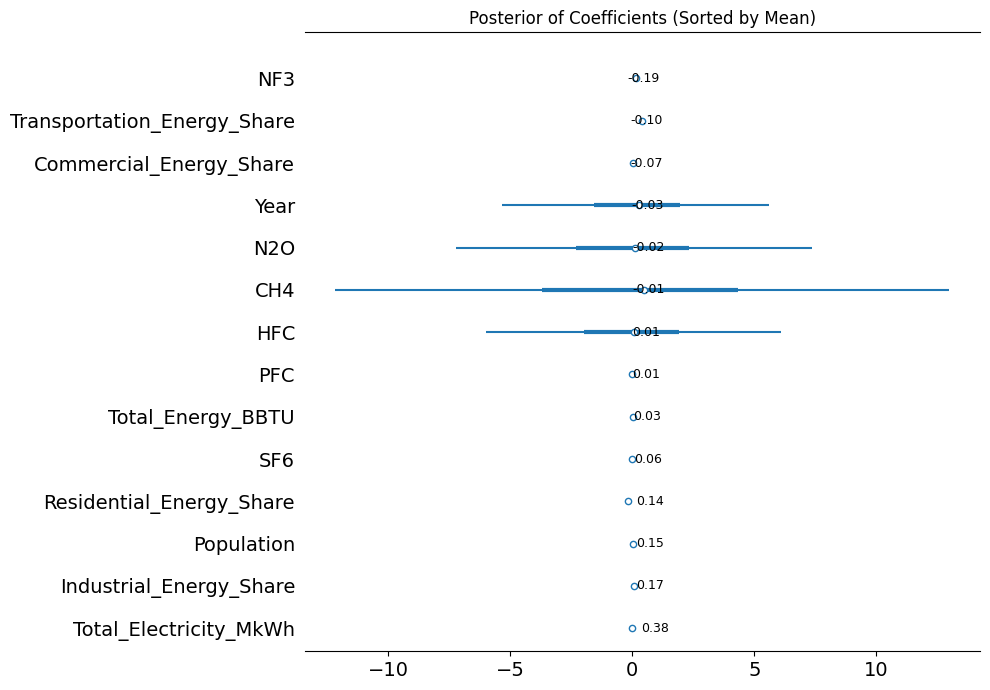

In [ ]:
# Extract posterior mean of beta
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw")).values
beta_squared = beta_mean ** 2

# Define feature names
feature_names = [
    'Population', 'Total_Electricity_MkWh', 'Total_Energy_BBTU',
    'Residential_Energy_Share', 'Commercial_Energy_Share',
    'Industrial_Energy_Share', 'Transportation_Energy_Share',
    'CH4', 'HFC', 'N2O', 'NF3', 'PFC', 'SF6', 'Year'
]

# Create DataFrame of beta values
beta_df = pd.DataFrame({
    'Feature': feature_names,
    'Posterior Mean': beta_mean})

# Sort by squared beta value
beta_df_sorted = beta_df.sort_values(by='Posterior Mean', ascending=False)

# Print the sorted beta table
print(beta_df_sorted.to_string(index=False))

# Feature names for posterior coefficients
feature_names = [
    'Population',
    'Total_Electricity_MkWh',
    'Total_Energy_BBTU',
    'Residential_Energy_Share', 'Commercial_Energy_Share',
    'Industrial_Energy_Share', 'Transportation_Energy_Share',
    'CH4', 'HFC', 'N2O', 'NF3', 'PFC', 'SF6', 'Year'
]

# Compute posterior mean and sort
beta_means = trace.posterior["beta"].mean(dim=("chain", "draw")).values
sorted_indices = np.argsort(beta_means)
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_means = beta_means[sorted_indices]

# Plot and extract axes
_, ax = plt.subplots(figsize=(10, len(feature_names) * 0.5))
forest_plot = az.plot_forest(trace, var_names=["beta"], combined=True,
                             hdi_prob=0.95, ax=ax)
# Get ytick positions from existing plot
yticks = ax.get_yticks()

# Assign new ytick labels
ax.set_yticklabels(sorted_features[::-1])  # reverse for top-bottom order

# Add posterior mean annotations at correct y positions
for y, mean in zip(yticks, sorted_means[::-1]):  # reverse to match plot
    ax.text(mean, y, f"{mean:.2f}", va='center', ha='left', fontsize=9)

plt.title("Posterior of Coefficients (Sorted by Mean)")
plt.tight_layout()
plt.show()

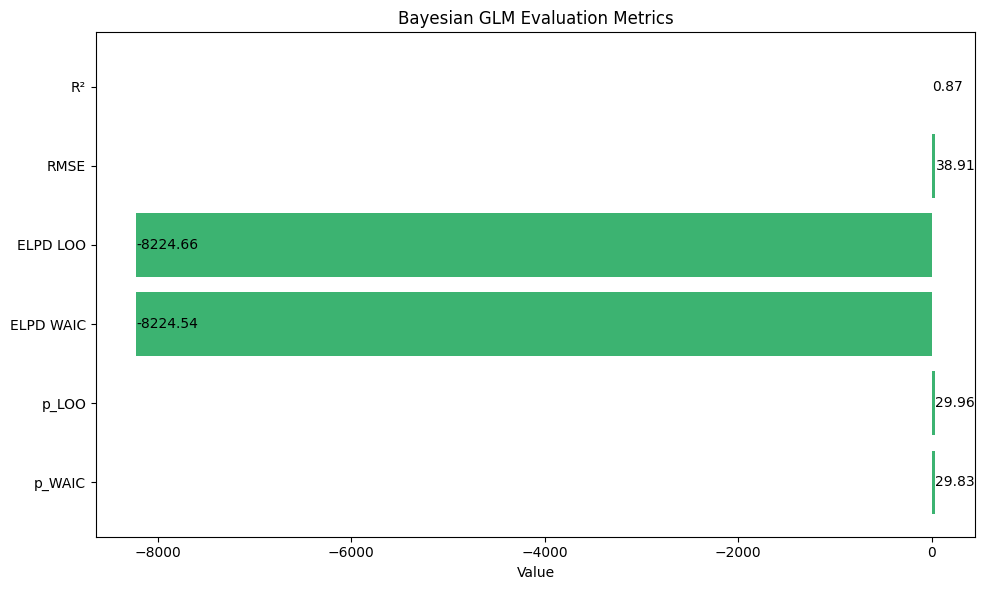

In [ ]:
# Define metrics and values
metrics = {
    "R²": 0.867,
    "RMSE": 38.91,
    "ELPD LOO": -8224.66,
    "ELPD WAIC": -8224.54,
    "p_LOO": 29.96,
    "p_WAIC": 29.83
}

# Separate keys and values
labels = list(metrics.keys())
values = list(metrics.values())

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color='mediumseagreen')
plt.xlabel("Value")
plt.title("Bayesian GLM Evaluation Metrics")

# Add data labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.gca().invert_yaxis()  # Most important metrics appear at top
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



=== RIDGE REGRESSION ===
Optimal alpha selected: 0.1
Ridge Regression (test) RMSE: 422.24, R²: 0.96


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Emissions                      1.000000
Total_Energy_BBTU              0.981419
Total_Electricity_MkWh         0.932667
CH4                            0.867534
Population                     0.824471
N2O                            0.654045
HFC                            0.607971
NF3                            0.362871
SF6                            0.345313
Industrial_Energy_Share        0.225047
PFC                            0.154062
Year                          -0.017445
Residential_Energy_Share      -0.125653
Transportation_Energy_Share   -0.159547
Commercial_Energy_Share       -0.161079
Name: Emissions, dtype: float64


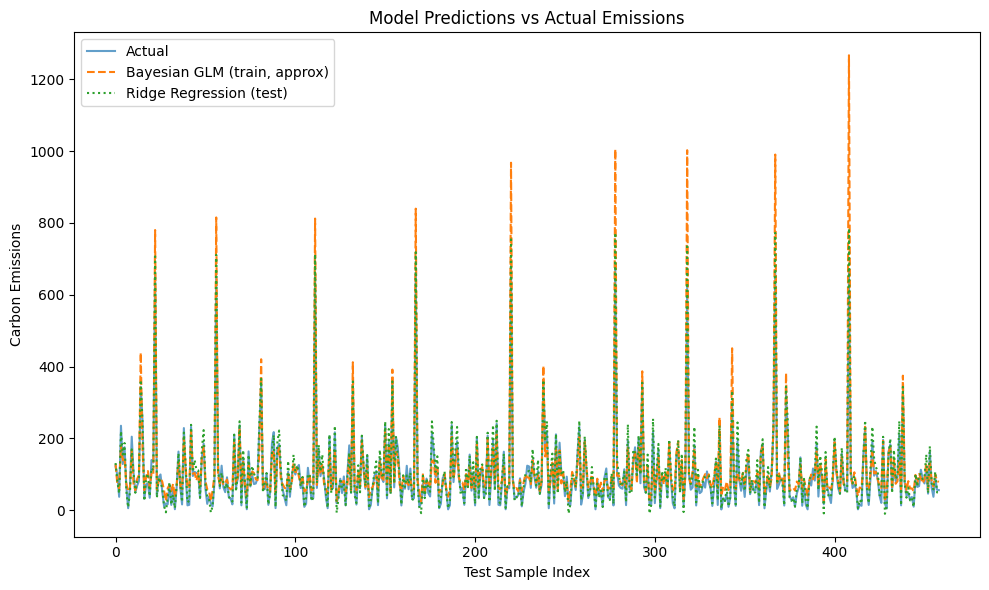

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

df = pd.read_csv('merged_df_q2.csv')

# Keep relevant columns
features = [
    'Population',
    'Total_Electricity_MkWh',
    'Total_Energy_BBTU',
    'Residential_Energy_Share',	'Commercial_Energy_Share',	'Industrial_Energy_Share',	'Transportation_Energy_Share',
    'CH4',	'HFC',	'N2O',	'NF3',	'PFC',	'SF6',
    'Year'
]
target = 'Emissions'

# Clean commas from numeric strings
for col in features + [target]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)


# Drop any rows with missing data
df = df[features + [target]].dropna()
# ---- TIME-BASED TRAIN-TEST SPLIT ----
df["Year"] = df["Year"].astype(int)
df_sorted = df.sort_values("Year")

# You can modify cutoff year as needed
train_df = df_sorted[df_sorted["Year"] <= 2013]
test_df = df_sorted[df_sorted["Year"] > 2013]

# Feature matrix and target

y_train = train_df[target].values

y_test = test_df[target].values

# DROP MISSING ROWS ONLY AFTER CLEANING AND DEFINING FEATURES
df = df[features + [target]].dropna()

# Time-based split — safe, avoids leakage
df["Year"] = df["Year"].astype(int)
df_sorted = df.sort_values("Year")

train_df = df_sorted[df_sorted["Year"] <= 2013].copy()
test_df = df_sorted[df_sorted["Year"] > 2013].copy()

# Split features and targets
X_train_raw = train_df[features].copy()
y_train = train_df[target].values

X_test_raw = test_df[features].copy()
y_test = test_df[target].values

# Apply scaling only on training data, then transform test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


# ---- RIDGE REGRESSION BLOCK ----
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], store_cv_values=True)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Output results
print("\n=== RIDGE REGRESSION ===")
print(f"Optimal alpha selected: {ridge.alpha_}")
evaluate_model("Ridge Regression (test)", y_test, y_pred_ridge)

# ---- PLOT ALL MODEL PREDICTIONS ----
plt.figure(figsize=(10, 6))

# Actual values
plt.plot(y_test, label="Actual", alpha=0.7)

# Define Bayesian GLM with Gamma likelihood
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_train.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1)

    mu = pm.math.exp(intercept + pm.math.dot(X_train, beta))
    y_obs = pm.Gamma("y_obs", mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

# Convert posterior means to NumPy
intercept_mean = trace.posterior["intercept"].mean().values.item()
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw")).values

# Predict on test set using posterior means
mu_test = np.exp(intercept_mean + np.dot(X_test, beta_mean))
y_pred_bayes = mu_test
print(df.corr(numeric_only=True)["Emissions"].sort_values(ascending=False))



# Bayesian GLM (Note: these are from training set unless you used posterior predictive on test)
plt.plot(y_pred_bayes[:len(y_test)], label="Bayesian GLM (train, approx)", linestyle='--')


# Ridge Regression
plt.plot(y_pred_ridge, label="Ridge Regression (test)", linestyle=':')

plt.title("Model Predictions vs Actual Emissions")
plt.xlabel("Test Sample Index")
plt.ylabel("Carbon Emissions")
plt.legend()
plt.tight_layout()
plt.show()